# XGBoost Regressor for Time-Series Forecasting

Source: 
Nour Mahamat Oumar,
Machine learning for time series forecasting using python

https://medium.com/@nouroumar93/machine-learning-for-time-series-forecasting-using-python-2e9b7444d741


### USE CASES :
For this case study, we use data on monthly passenger numbers for US Airline between 1949 and 1960. These data are from kaggle :

https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python/data

In [1]:
# !pip install pip install bayesian-optimization

In [2]:
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import datetime
import calendar

import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
# define min max scaler
scaler = MinMaxScaler()
# transform data
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [3]:
path = "data/AirPassengers.csv"
Data = pd.read_csv(path)
Data.tail(10)

,Month,#Passengers
134,1960-03,419
135,1960-04,461
136,1960-05,472
137,1960-06,535
138,1960-07,622
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


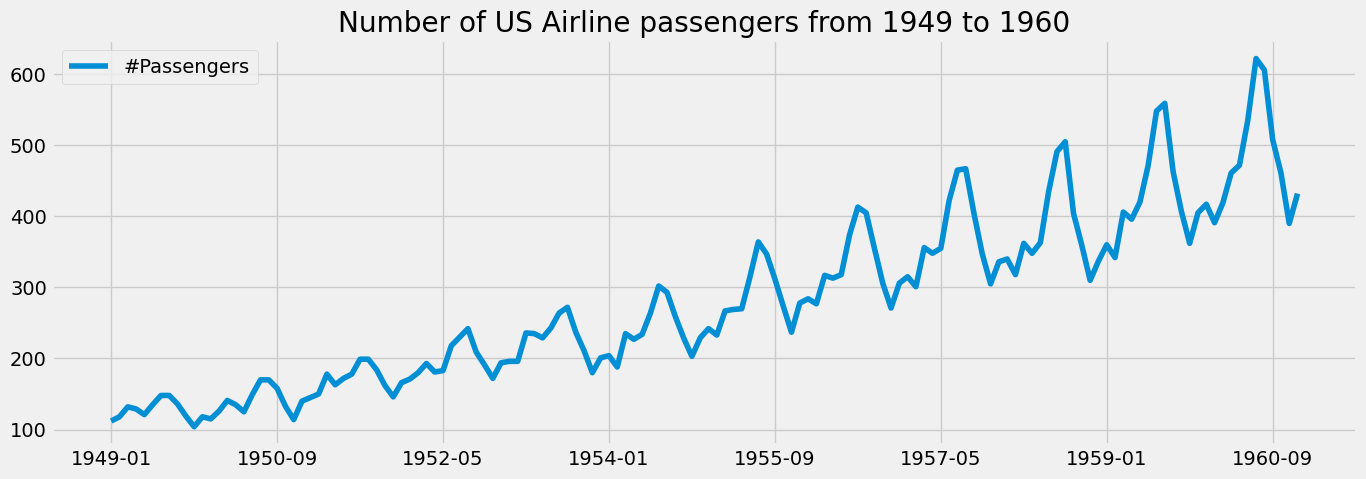

In [4]:
Data.index = Data["Month"]
Data.index.names = ['']

Data_v1 = Data.copy()
Data_v1 = Data_v1[["#Passengers"]]

_ =Data_v1 \
    .plot(figsize=(15,5), title='Number of US Airline passengers from 1949 to 1960')


In [7]:
# Features Engineering

# Temporal features

def create_features(data, date):
    ### Create Date indicators
    data["Year"]         = pd.to_datetime(data[date]).dt.year
    data["Quarter"]      = pd.to_datetime(data[date]).dt.quarter
    data["Month"]        = pd.to_datetime(data[date]).dt.month
    data["Semester"]     = data["Month"].map(lambda x: 1 if x<=6 else 2)
    return data

In [8]:
Data_feature = create_features(Data, "Month")
Data_feature

,Month,#Passengers,Year,Quarter,Semester
,,,,,
1949-01,1,112,1949,1,1
1949-02,2,118,1949,1,1
1949-03,3,132,1949,1,1
1949-04,4,129,1949,2,1
1949-05,5,121,1949,2,1
...,...,...,...,...,...
1960-08,8,606,1960,3,2
1960-09,9,508,1960,3,2
1960-10,10,461,1960,4,2


In [10]:
# Rolling variables:

def create_lag_variable(data, n_lag, cible):
    data['lag_'+str(n_lag)] = data[cible].shift(n_lag)
    data = data.dropna()
    return data


def create_lag_and_rolling_indicator_week(Data,nb_lag):
    DataFINAL = Data.copy()

    DataFINAL["Trend"]=range(1,DataFINAL.shape[0]+1)
    
    DataFINAL['3-Month Rolling Mean'] =  DataFINAL["#Passengers"].rolling(3).mean().shift(1)
    DataFINAL['3-Month Rolling Max']  =  DataFINAL["#Passengers"].rolling(3).max().shift(1)
    DataFINAL['3-Month Rolling Min']  =  DataFINAL["#Passengers"].rolling(3).min().shift(1)
    DataFINAL['3-Month Rolling Sum']  =  DataFINAL["#Passengers"].rolling(3).sum().shift(1)
    DataFINAL['3-Month Rolling STD']  =  DataFINAL["#Passengers"].rolling(3).std().shift(1)
    
    DataFINAL['2-Month Rolling Mean'] =  DataFINAL["#Passengers"].rolling(2).mean().shift(1)
    DataFINAL['2-Month Rolling Max']  =  DataFINAL["#Passengers"].rolling(2).max().shift(1)
    DataFINAL['2-Month Rolling Min']  =  DataFINAL["#Passengers"].rolling(2).min().shift(1)
    DataFINAL['2-Month Rolling Sum']  =  DataFINAL["#Passengers"].rolling(2).sum().shift(1)
    DataFINAL['2-Month Rolling STD']  =  DataFINAL["#Passengers"].rolling(2).std().shift(1)

    
    DataFINAL_Lag = DataFINAL.copy()
    for lag in range(1,nb_lag):
        DataFINAL_Lag = create_lag_variable(DataFINAL_Lag, lag, "#Passengers")

    return DataFINAL_Lag

In [11]:
Data_feature_final = create_lag_and_rolling_indicator_week(Data_feature,3)

Data_feature_final

,Month,#Passengers,Year,Quarter,Semester,Trend,3-Month Rolling Mean,3-Month Rolling Max,3-Month Rolling Min,3-Month Rolling Sum,3-Month Rolling STD,2-Month Rolling Mean,2-Month Rolling Max,2-Month Rolling Min,2-Month Rolling Sum,2-Month Rolling STD,lag_1,lag_2
,,,,,,,,,,,,,,,,,,
1949-06,6,135,1949,2,1,6,127.333333,132.0,121.0,382.0,5.686241,125.0,129.0,121.0,250.0,5.656854,121.0,129.0
1949-07,7,148,1949,3,2,7,128.333333,135.0,121.0,385.0,7.023769,128.0,135.0,121.0,256.0,9.899495,135.0,121.0
1949-08,8,148,1949,3,2,8,134.666667,148.0,121.0,404.0,13.503086,141.5,148.0,135.0,283.0,9.192388,148.0,135.0
1949-09,9,136,1949,3,2,9,143.666667,148.0,135.0,431.0,7.505553,148.0,148.0,148.0,296.0,0.000000,148.0,148.0
1949-10,10,119,1949,4,2,10,144.000000,148.0,136.0,432.0,6.928203,142.0,148.0,136.0,284.0,8.485281,136.0,148.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960-08,8,606,1960,3,2,140,543.000000,622.0,472.0,1629.0,75.319320,578.5,622.0,535.0,1157.0,61.518290,622.0,535.0
1960-09,9,508,1960,3,2,141,587.666667,622.0,535.0,1763.0,46.306947,614.0,622.0,606.0,1228.0,11.313708,606.0,622.0
1960-10,10,461,1960,4,2,142,578.666667,622.0,508.0,1736.0,61.719797,557.0,606.0,508.0,1114.0,69.296465,508.0,606.0


In [12]:
# Split data to train and test

def split_train_test(Data_feature_final, split_date = "1959-01"):
    
    data_train =None
    data_test =None
    data_train = Data_feature_final.loc[Data_feature_final.index < split_date].copy()
    data_test  = Data_feature_final.loc[Data_feature_final.index >= split_date].copy()
    #data_test  = data_test.loc[data_test.index.astype(str) < "2019-12-01"].copy()
    return data_train, data_test

In [13]:
data_train, data_test = split_train_test(Data_feature_final, split_date = "1959-01")

data_test

,Month,#Passengers,Year,Quarter,Semester,Trend,3-Month Rolling Mean,3-Month Rolling Max,3-Month Rolling Min,3-Month Rolling Sum,3-Month Rolling STD,2-Month Rolling Mean,2-Month Rolling Max,2-Month Rolling Min,2-Month Rolling Sum,2-Month Rolling STD,lag_1,lag_2
,,,,,,,,,,,,,,,,,,
1959-01,1,360,1959,1,1,121,335.333333,359.0,310.0,1006.0,24.542480,323.5,337.0,310.0,647.0,19.091883,337.0,310.0
1959-02,2,342,1959,1,1,122,335.666667,360.0,310.0,1007.0,25.026652,348.5,360.0,337.0,697.0,16.263456,360.0,337.0
1959-03,3,406,1959,1,1,123,346.333333,360.0,337.0,1039.0,12.096832,351.0,360.0,342.0,702.0,12.727922,342.0,360.0
1959-04,4,396,1959,2,1,124,369.333333,406.0,342.0,1108.0,33.005050,374.0,406.0,342.0,748.0,45.254834,406.0,342.0
1959-05,5,420,1959,2,1,125,381.333333,406.0,342.0,1144.0,34.428670,401.0,406.0,396.0,802.0,7.071068,396.0,406.0
1959-06,6,472,1959,2,1,126,407.333333,420.0,396.0,1222.0,12.055428,408.0,420.0,396.0,816.0,16.970563,420.0,396.0
1959-07,7,548,1959,3,2,127,429.333333,472.0,396.0,1288.0,38.850139,446.0,472.0,420.0,892.0,36.769553,472.0,420.0
1959-08,8,559,1959,3,2,128,480.000000,548.0,420.0,1440.0,64.373908,510.0,548.0,472.0,1020.0,53.740115,548.0,472.0
1959-09,9,463,1959,3,2,129,526.333333,559.0,472.0,1579.0,47.374395,553.5,559.0,548.0,1107.0,7.778175,559.0,548.0


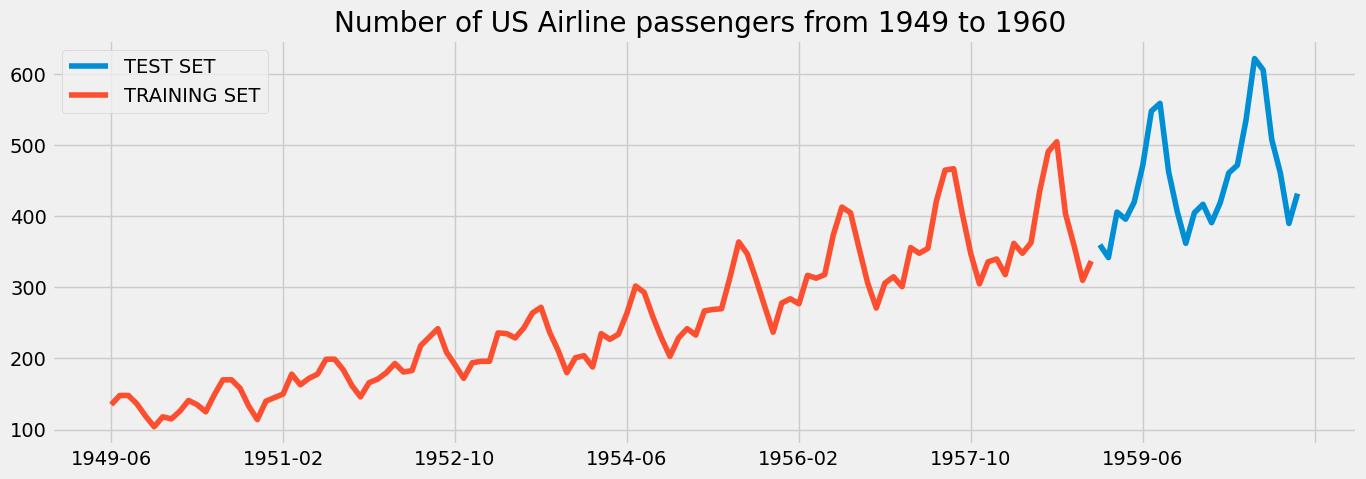

In [14]:
_ = data_test[['#Passengers']] \
    .rename(columns={'#Passengers': 'TEST SET'}) \
    .join(data_train[['#Passengers']].rename(columns={'#Passengers': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Number of US Airline passengers from 1949 to 1960 ')

In [15]:
# Training a machine learning prediction model

def mean_absolute_percentage_error(y_true,y_pred): 
        """Calculates MAPE given y_true and y_pred"""
        dat_ = pd.DataFrame()
        dat_["y_true"]=list(y_true)
        dat_["y_pred"] =y_pred
        dat_=dat_[dat_["y_true"]!=0]
        y_true, y_pred = np.array(dat_["y_true"]), np.array(dat_["y_pred"])
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def xgb_evaluate(max_depth, gamma ,subsample,eta):
        params = {'eval_metric': "rmse",
              'max_depth': int(max_depth),
              'subsample': subsample,
              'eta':eta,
              'gamma': gamma,
              #'colsample_bytree': colsample_bytree
                 }
    
        model = XGBRegressor( **params)
        model2 = model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False, early_stopping_rounds=20)
    
        # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
        return -(1.0 * mean_absolute_percentage_error(y_test,model2.predict(X_test)))

In [27]:
# Training the XGBoost model

def Model_training(data_train,data_test):
    
    def mean_absolute_percentage_error(y_true,y_pred): 
        """Calculates MAPE given y_true and y_pred"""
        dat_ = pd.DataFrame()
        dat_["y_true"]=list(y_true)
        dat_["y_pred"] =y_pred
        dat_=dat_[dat_["y_true"]!=0]
        y_true, y_pred = np.array(dat_["y_true"]), np.array(dat_["y_pred"])
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    def xgb_evaluate(max_depth, gamma ,subsample,eta):
        params = {'eval_metric': "rmse",
              'max_depth': int(max_depth),
              'subsample': subsample,
              'eta':eta,
              'gamma': gamma,
              #'colsample_bytree': colsample_bytree
                 }
    
        model = XGBRegressor( **params)
        # model2 = model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
        #       verbose=False, early_stopping_rounds=20)
        model2 = model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False)
        
        # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
        return -(1.0 * mean_absolute_percentage_error(y_test,model2.predict(X_test)))

    X_train = pd.DataFrame(data_train.drop(['#Passengers'], axis=1))
    y_train = data_train['#Passengers']
    
    X_test = pd.DataFrame(data_test.drop(['#Passengers'], axis=1))
    y_test = data_test['#Passengers']
        
    xgb_bo =None
    xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 200), 
                                                 'gamma': (0, 5),
                                                 #'colsample_bytree': (0.3, 0.9),
                                                 #"subsample":(0.5,0.9),
                                                 "subsample":(1,1),
                                                 "eta": (0.1,0.5)})
    # Use the expected improvement acquisition function to handle negative numbers
    # Optimally needs quite a few more initiation points and number of iterations
    # xgb_bo.maximize(init_points=3, n_iter=100, acq='ei')
    xgb_bo.maximize(init_points=3, n_iter=100)
    
    params = xgb_bo.max['params']
    params['max_depth'] = int(params['max_depth'])

    
    #model2 = xgb.train(params, dtrain, num_boost_round=250)
    model_impl = XGBRegressor(**params)
    # model_Fitted = model_impl.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
    #         verbose=False, early_stopping_rounds=10)
    model_Fitted = model_impl.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=False)
    
    # Predict on testing and training set
    y_pred = model_Fitted.predict(X_test)
    y_train_pred = model_Fitted.predict(X_train)
    
    data_test["y_pred"] = y_pred
    data_test_1 =data_test.copy()
    
    data_test_1=data_test_1[data_test_1["#Passengers"]!=0]
    
    data_test_1["ec"] = data_test_1["#Passengers"] - data_test_1["y_pred"]
        
    mape_value =  np.round(np.mean(np.abs(100*np.array(data_test_1["ec"])/np.array(data_test_1["#Passengers"]))), 0)
   
    return model_Fitted,data_train,data_test, mape_value

In [28]:
# Performance of Model
print("ok")
mL_ , train_, test_, Mape = Model_training(data_train, data_test)

print(Mape)

ok
|   iter    |  target   |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------
| 1         | -10.17    | 0.4939    | 3.691     | 19.73     | 1.0       |
| 2         | -9.771    | 0.1993    | 1.883     | 171.6     | 1.0       |
| 3         | -9.404    | 0.1128    | 3.284     | 34.26     | 1.0       |
| 4         | -10.11    | 0.2038    | 3.626     | 69.38     | 1.0       |
| 5         | -10.18    | 0.1738    | 2.259     | 114.1     | 1.0       |
| 6         | -9.981    | 0.394     | 1.882     | 104.4     | 1.0       |
| 7         | -10.27    | 0.2863    | 2.822     | 34.96     | 1.0       |
| 8         | -9.734    | 0.1415    | 4.166     | 163.0     | 1.0       |
| 9         | -10.6     | 0.2719    | 1.907     | 26.04     | 1.0       |
| 10        | -11.55    | 0.3024    | 4.837     | 145.2     | 1.0       |
| 11        | -9.815    | 0.248     | 1.519     | 103.9     | 1.0       |
| 12        | -9.819    | 0.1818   

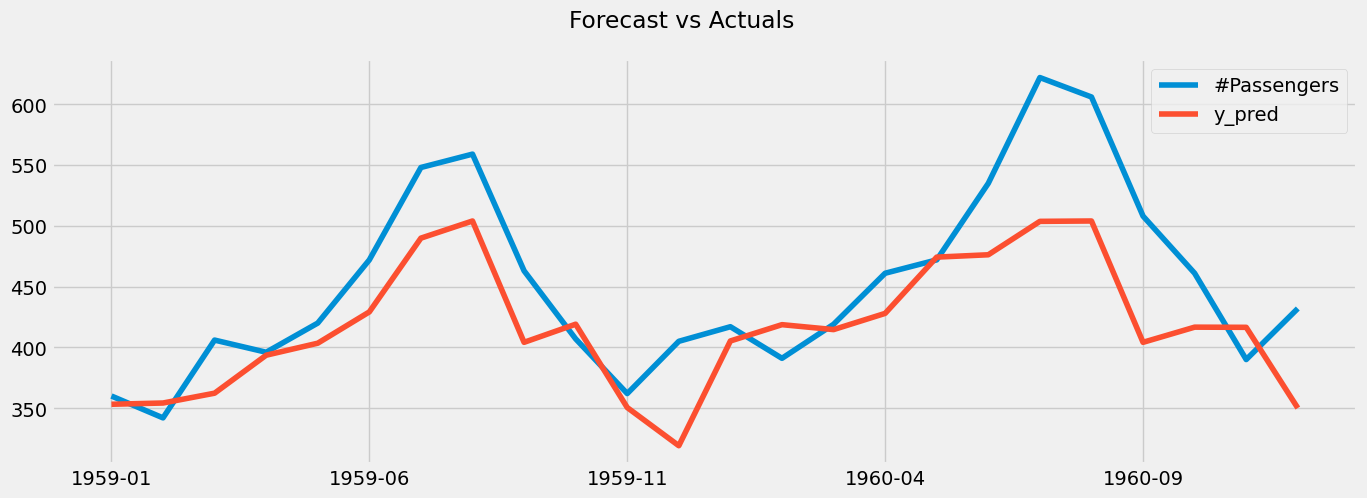

In [29]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

_ = test_[((test_["#Passengers"]>0))][['#Passengers','y_pred']].plot(ax=ax,style=['-','-'])
plot = plt.suptitle('Forecast vs Actuals')